<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/gans/acgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Conditional Image Synthesis with Auxiliary Classifier GANs](https://arxiv.org/pdf/1610.09585.pdf)

In [15]:
import torch
import torch.nn as nn
import math
import numpy as np
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

In [16]:
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 100
n_classes = 10
img_size = 32
channels = 1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
img_shape = (channels,img_size,img_size)
display_step = 5000

In [17]:
def weight_init_normal(m : nn.Module):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data,1.0,0.02)
        torch.nn.init.constant_(m.bias.data,0.0)

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        self.label_embedding = nn.Embedding(n_classes,latent_dim)
        self.init_size = img_size // 4 # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim,128* self.init_size **2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128,128,3,stride = 1,padding =1),
            nn.BatchNorm2d(128,0.8),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128,64,3,stride = 1,padding = 1),
            nn.BatchNorm2d(64,0.8),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Conv2d(64,channels,3,stride = 1,padding = 1),
            nn.Tanh()
        )
    def forward(self,noise,labels):
        out = self.label_embedding(labels)
        gen_input = torch.mul(self.label_embedding(labels),noise)
        out = self.l1(gen_input)
        out = out.view(out.size(0),128,self.init_size,self.init_size)
        out = self.conv_blocks(out)
        return out


In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        def discriminator_block(in_feats,out_feats,bn = True):
            layers = [nn.Conv2d(in_feats,out_feats,3,2,1),nn.LeakyReLU(0.2,inplace = True),nn.Dropout(0.25)]
            if bn:
                layers.append(nn.BatchNorm2d(out_feats,0.8))
            return layers
        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels,16,bn = False),
            *discriminator_block(16,32),
            *discriminator_block(32,64),
            *discriminator_block(64,128)
        )
        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4

        #output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size**2,1),nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128*ds_size **2,n_classes),nn.Softmax())

    def forward(self,img):
        out = self.conv_blocks(img)
        out = out.view(out.size(0),-1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return validity, label

In [20]:
adversarial_loss = nn.BCELoss()
auxialiary_loss = nn.CrossEntropyLoss()

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weight_init_normal)
discriminator.apply(weight_init_normal)

optimizer_G  = torch.optim.Adam(generator.parameters(),lr = lr,betas = (b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(),lr = lr, betas = (b1,b2))

In [21]:
dataloader = DataLoader(
    datasets.MNIST(
        './root',
        download = True,
        train = True,
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
    ),
    batch_size = batch_size,
    shuffle = True
)

In [22]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

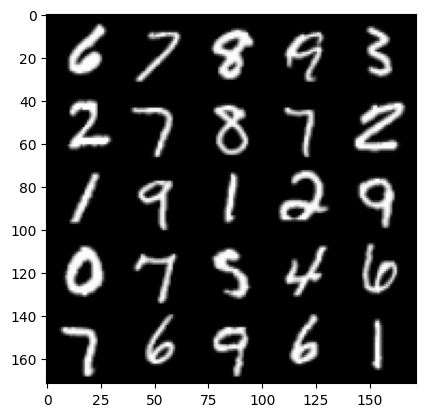

In [23]:

images,labels = next(iter(dataloader))
show_tensor_images(images)

Training

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
 33%|███▎      | 310/938 [00:10<00:19, 31.62it/s]

[Epoch 5], step 5000: [G loss:1.3616514885425546], [D loss:2.469403617095944,acc : 85.9375]


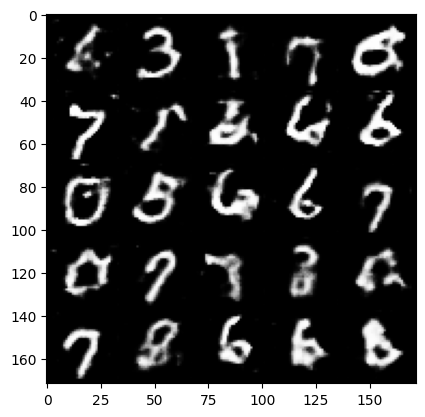

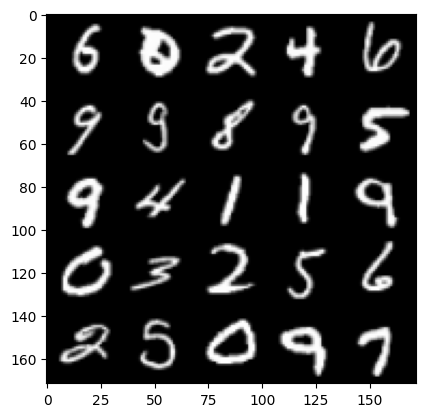

 66%|██████▌   | 618/938 [00:21<00:10, 30.37it/s]

[Epoch 10], step 10000: [G loss:1.2465698356270734], [D loss:2.2043972286462767,acc : 93.75]


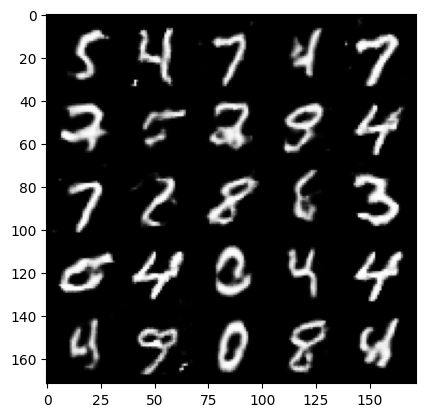

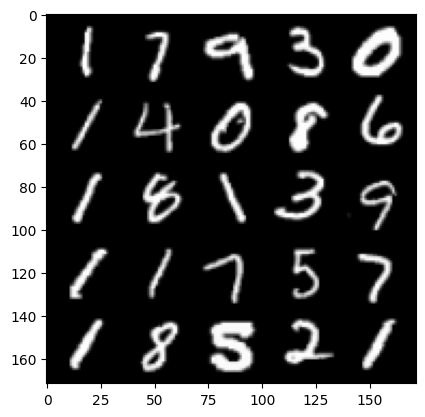

 99%|█████████▉| 930/938 [00:31<00:00, 30.87it/s]

[Epoch 15], step 15000: [G loss:1.1898218471646311], [D loss:2.1807917788982354,acc : 91.40625]


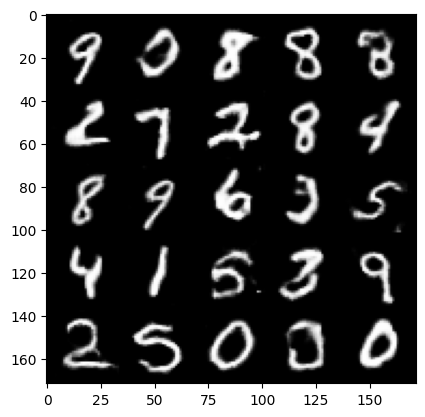

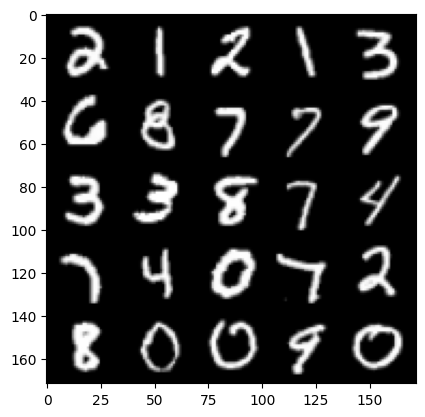

 32%|███▏      | 302/938 [00:10<00:21, 29.88it/s]

[Epoch 21], step 20000: [G loss:1.1618970769405377], [D loss:2.17280068702698,acc : 94.53125]


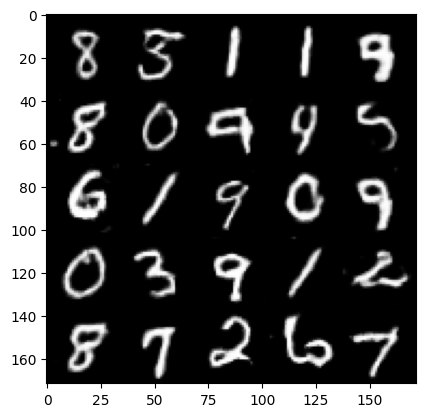

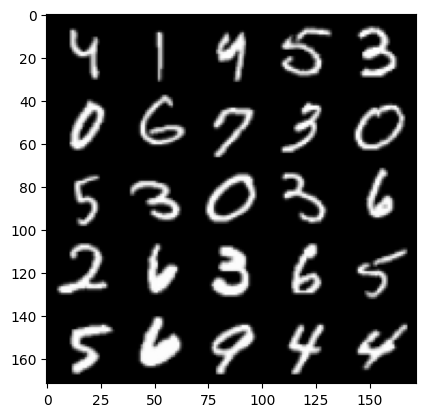

 65%|██████▌   | 610/938 [00:21<00:14, 22.75it/s]

[Epoch 26], step 25000: [G loss:1.150408784353735], [D loss:2.164084137320522,acc : 95.3125]


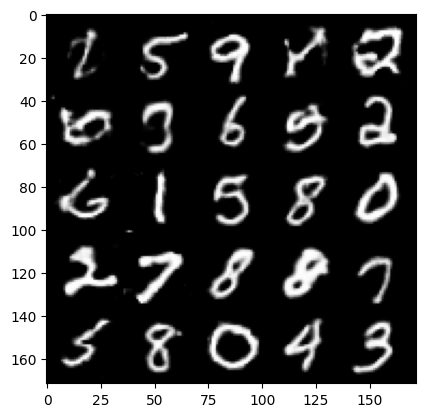

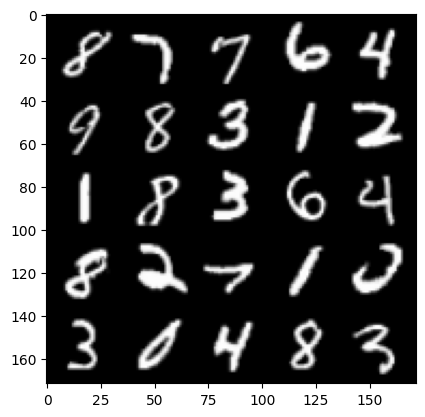

 98%|█████████▊| 922/938 [00:32<00:00, 30.46it/s]

[Epoch 31], step 30000: [G loss:1.1448489004254339], [D loss:2.1546469296932225,acc : 98.4375]


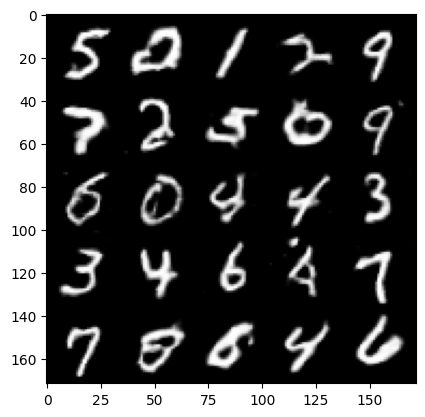

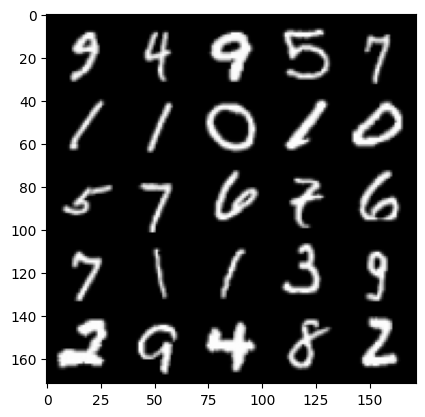

 31%|███▏      | 294/938 [00:11<00:23, 27.77it/s]

[Epoch 37], step 35000: [G loss:1.1353296345233952], [D loss:2.152650090837475,acc : 98.4375]


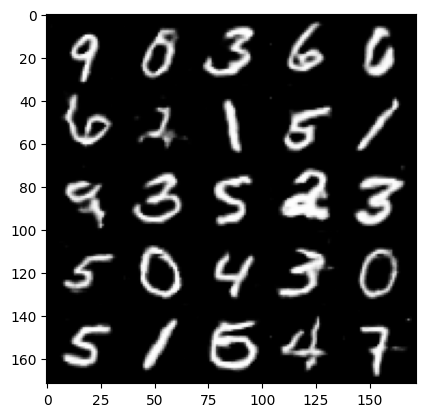

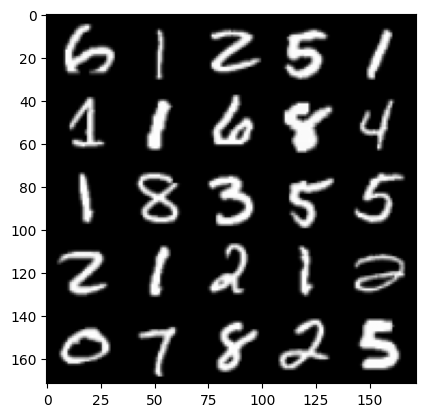

 64%|██████▍   | 604/938 [00:21<00:14, 22.74it/s]

[Epoch 42], step 40000: [G loss:1.1287103537797931], [D loss:2.152382314801222,acc : 95.3125]


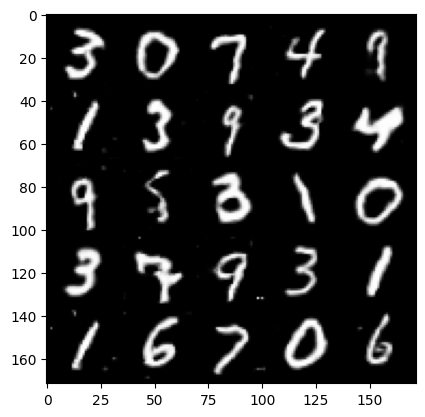

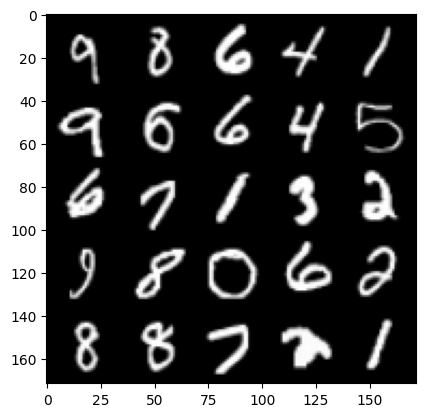

 97%|█████████▋| 914/938 [00:32<00:00, 29.34it/s]

[Epoch 47], step 45000: [G loss:1.128724220347405], [D loss:2.149572719764706,acc : 92.96875]


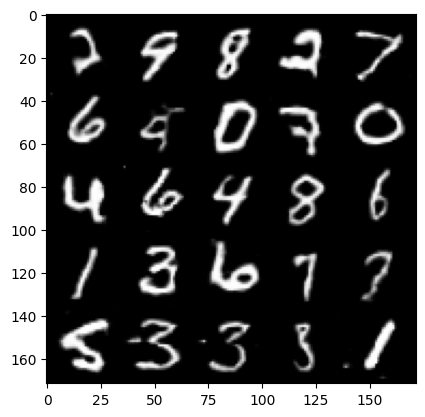

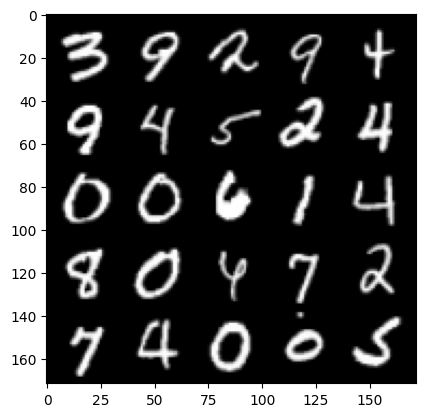

 30%|███       | 283/938 [00:10<00:22, 29.75it/s]

[Epoch 53], step 50000: [G loss:1.1349689741253841], [D loss:2.143413923048964,acc : 97.65625]


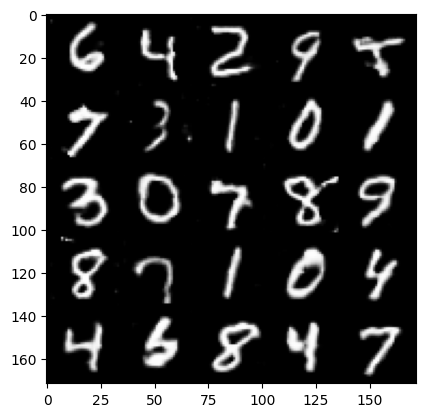

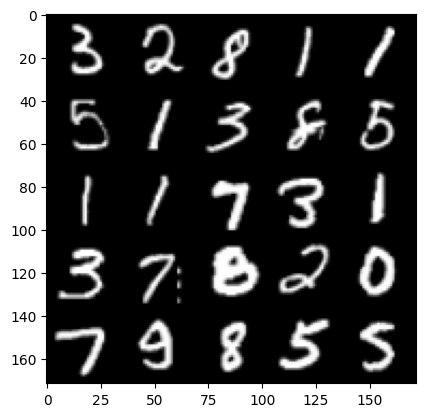

 63%|██████▎   | 594/938 [00:21<00:11, 28.79it/s]

[Epoch 58], step 55000: [G loss:1.1386937809824906], [D loss:2.1418176374912323,acc : 98.4375]


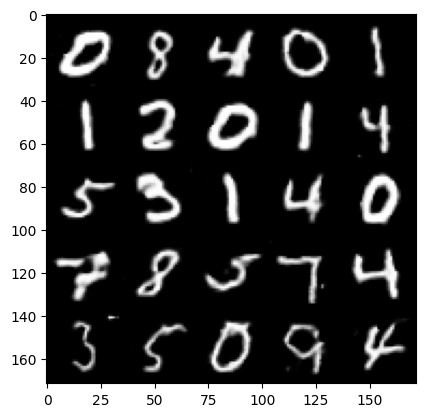

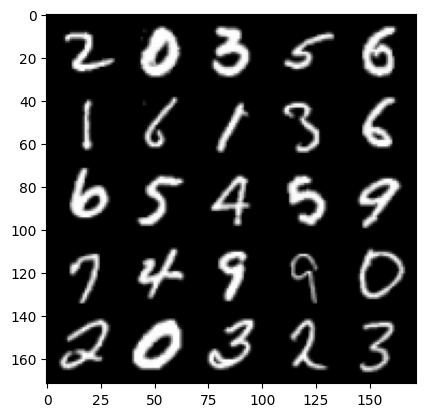

 96%|█████████▋| 904/938 [00:32<00:01, 22.66it/s]

[Epoch 63], step 60000: [G loss:1.141677859306336], [D loss:2.1359086260557283,acc : 98.4375]


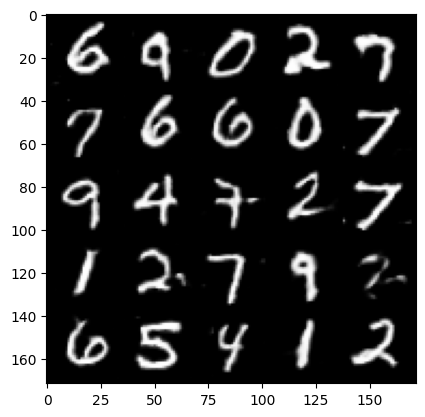

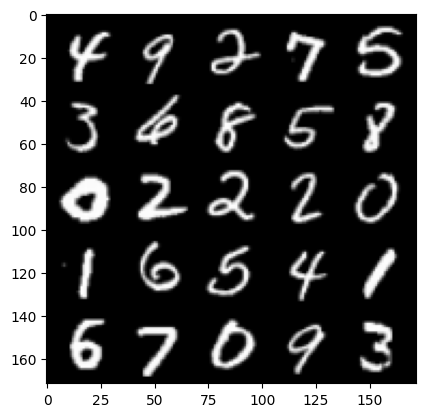

 30%|██▉       | 278/938 [00:09<00:22, 29.84it/s]

[Epoch 69], step 65000: [G loss:1.1460476852178556], [D loss:2.131679632282257,acc : 99.21875]


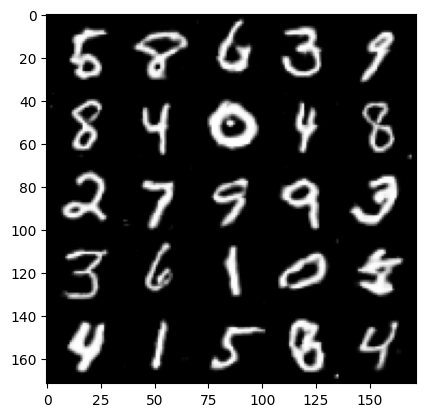

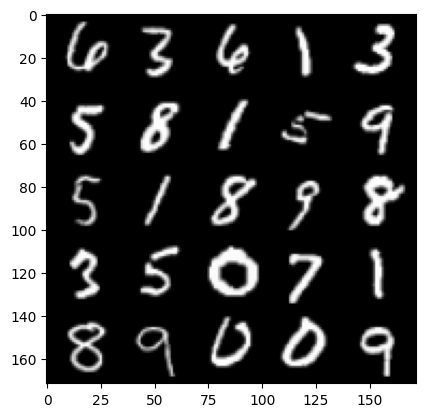

 62%|██████▏   | 585/938 [00:20<00:11, 30.26it/s]

[Epoch 74], step 70000: [G loss:1.14976425768137], [D loss:2.1302990670681026,acc : 97.65625]


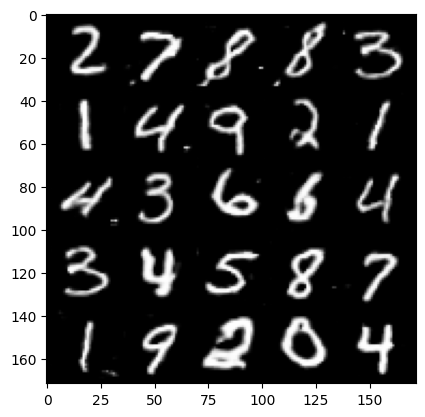

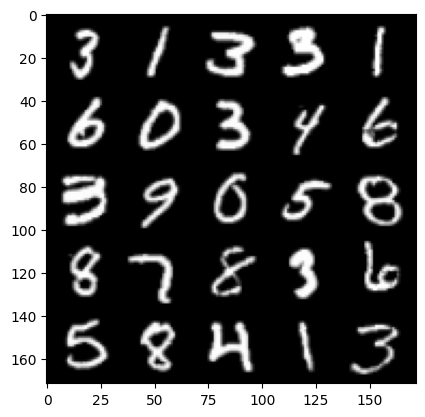

 96%|█████████▌| 896/938 [00:32<00:01, 27.73it/s]

[Epoch 79], step 75000: [G loss:1.158429684948924], [D loss:2.1256304819822294,acc : 92.96875]


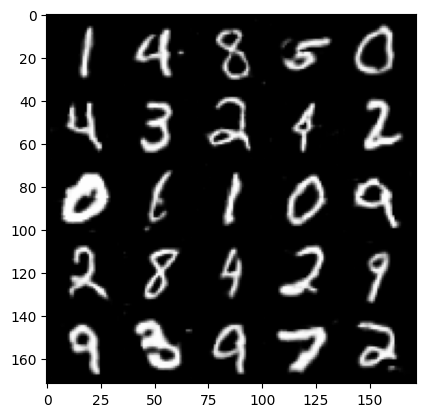

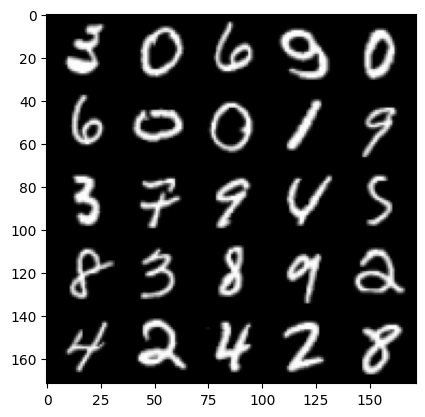

 29%|██▉       | 270/938 [00:10<00:23, 28.09it/s]

[Epoch 85], step 80000: [G loss:1.1655670314669608], [D loss:2.118059654283522,acc : 94.53125]


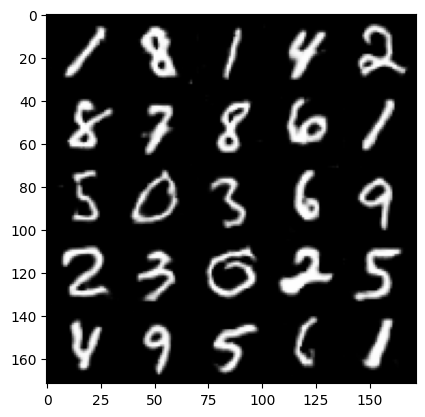

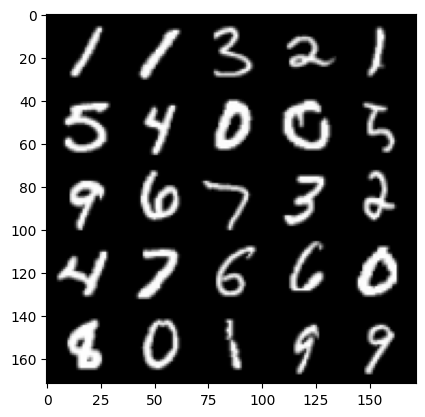

 62%|██████▏   | 579/938 [00:21<00:13, 26.96it/s]

[Epoch 90], step 85000: [G loss:1.1794170940995239], [D loss:2.1086588693380377,acc : 96.09375]


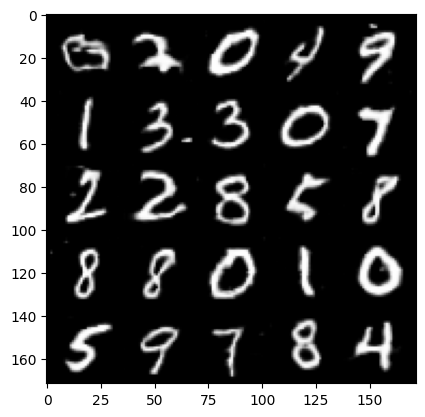

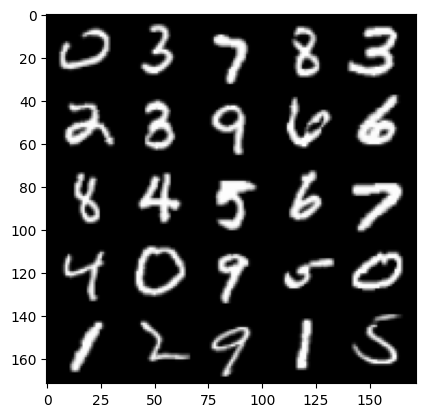

 95%|█████████▍| 888/938 [00:33<00:01, 27.44it/s]

[Epoch 95], step 90000: [G loss:1.1852331133961647], [D loss:2.107398877716057,acc : 96.09375]


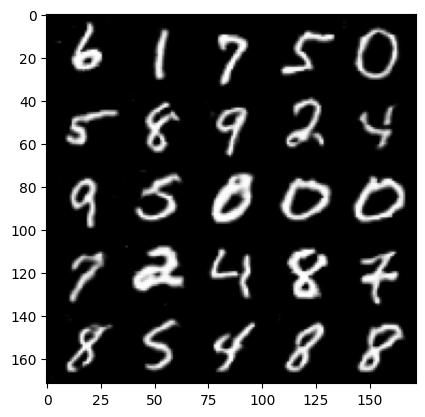

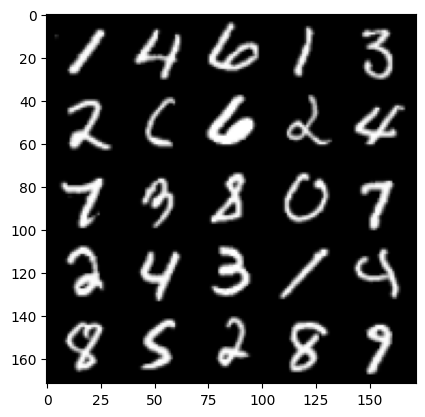

 28%|██▊       | 261/938 [00:09<00:24, 27.92it/s]

[Epoch 101], step 95000: [G loss:1.1952690843105314], [D loss:2.098523616743084,acc : 96.875]


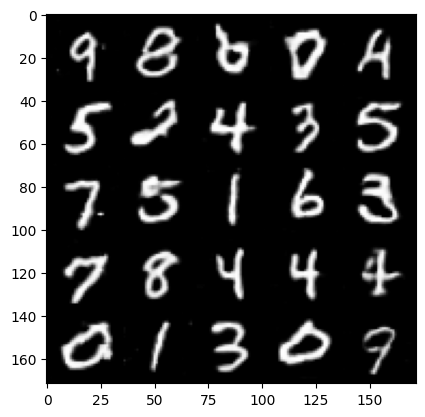

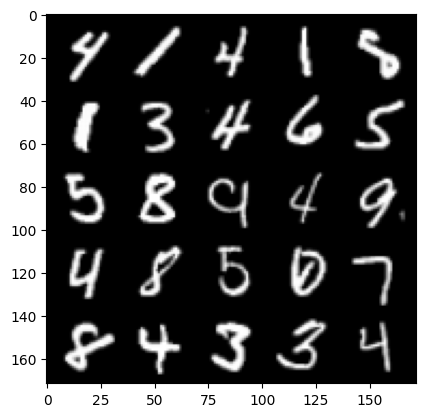

 61%|██████    | 570/938 [00:21<00:13, 26.85it/s]

[Epoch 106], step 100000: [G loss:1.2064665080428125], [D loss:2.0872293894767786,acc : 96.875]


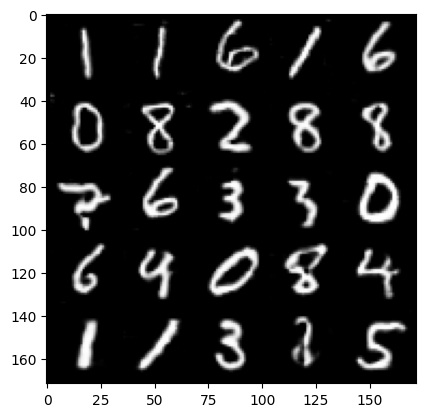

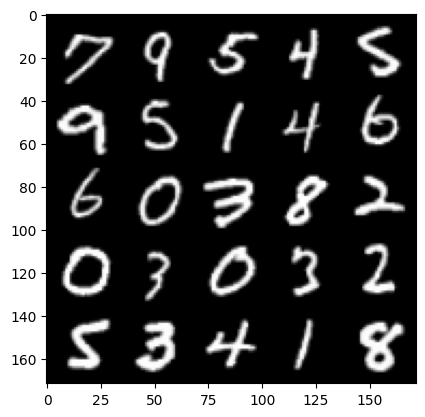

 94%|█████████▍| 882/938 [00:33<00:02, 27.63it/s]

[Epoch 111], step 105000: [G loss:1.227762907838821], [D loss:2.07416910865307,acc : 96.875]


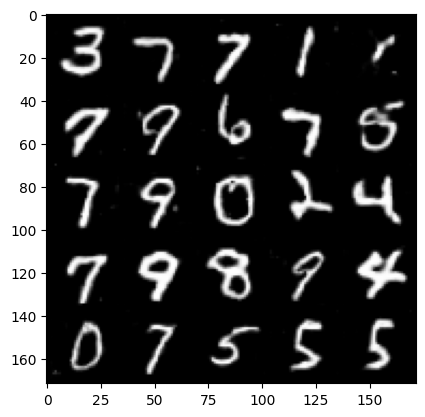

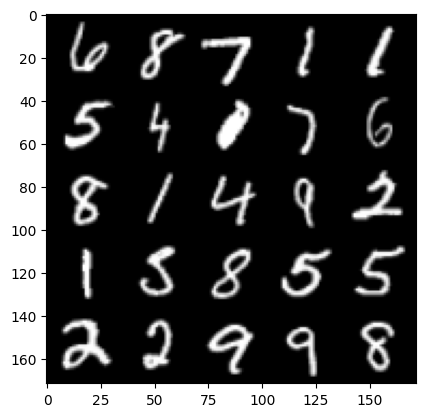

 27%|██▋       | 252/938 [00:09<00:25, 26.69it/s]

[Epoch 117], step 110000: [G loss:1.2422451305031732], [D loss:2.066013684630397,acc : 96.875]


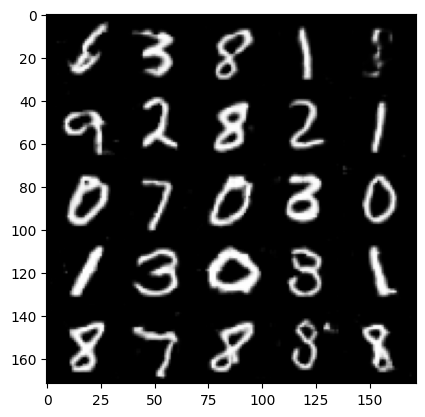

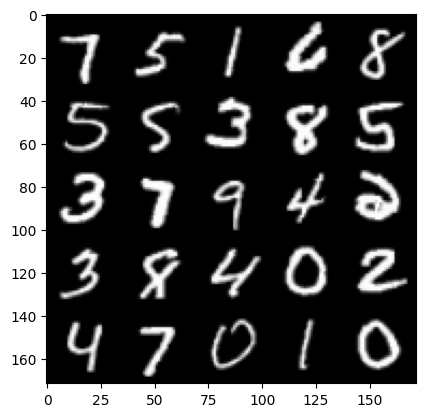

 60%|██████    | 564/938 [00:21<00:13, 27.25it/s]

[Epoch 122], step 115000: [G loss:1.261099888062479], [D loss:2.0583719165325154,acc : 97.65625]


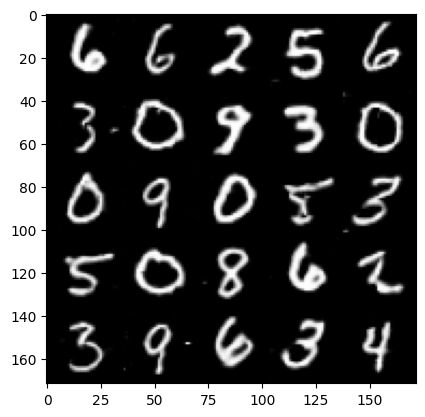

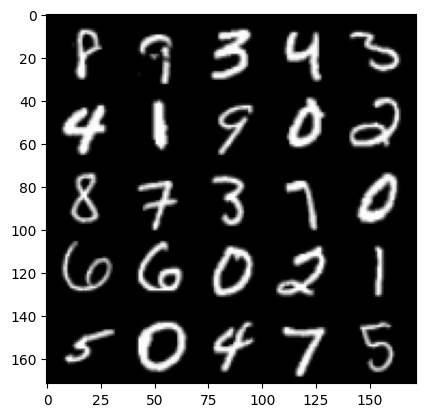

 93%|█████████▎| 872/938 [00:33<00:02, 26.79it/s]

[Epoch 127], step 120000: [G loss:1.2757810751795757], [D loss:2.0485964584827445,acc : 96.09375]


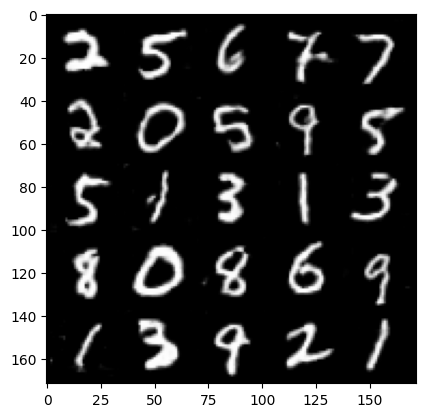

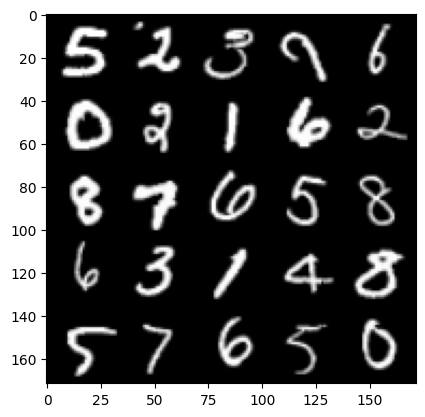

 26%|██▌       | 246/938 [00:09<00:26, 26.51it/s]

[Epoch 133], step 125000: [G loss:1.2984216559410096], [D loss:2.0326703791856726,acc : 96.09375]


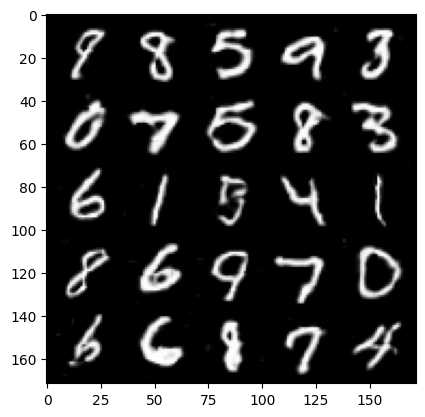

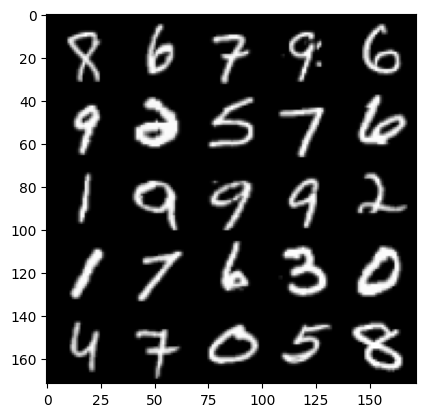

 59%|█████▉    | 555/938 [00:21<00:13, 27.50it/s]

[Epoch 138], step 130000: [G loss:1.3296948161005986], [D loss:2.0227366218566885,acc : 96.09375]


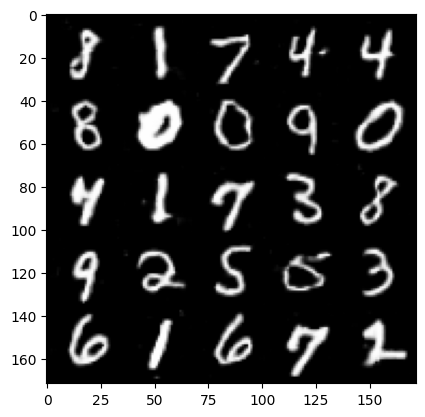

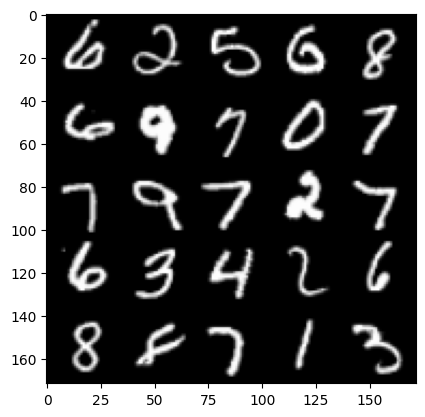

 92%|█████████▏| 864/938 [00:33<00:02, 26.46it/s]

[Epoch 143], step 135000: [G loss:1.353793783140181], [D loss:2.002505066561703,acc : 96.875]


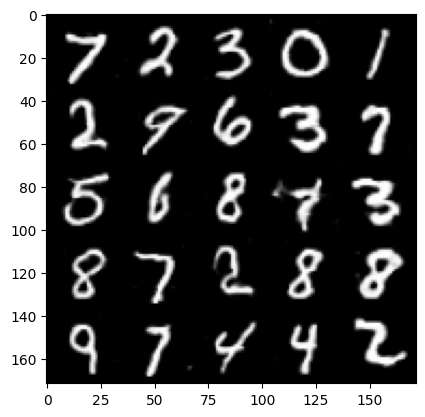

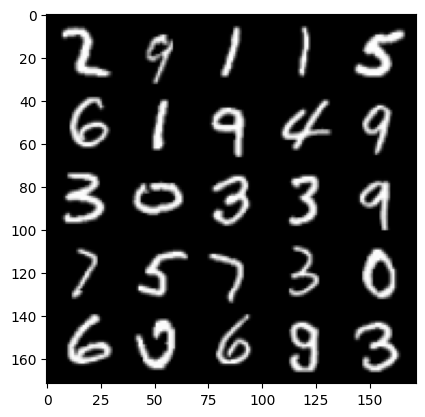

 25%|██▌       | 237/938 [00:09<00:26, 26.42it/s]

[Epoch 149], step 140000: [G loss:1.3842308093190197], [D loss:1.9822346264123882,acc : 93.75]


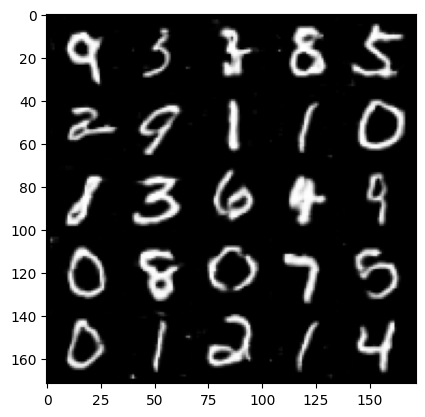

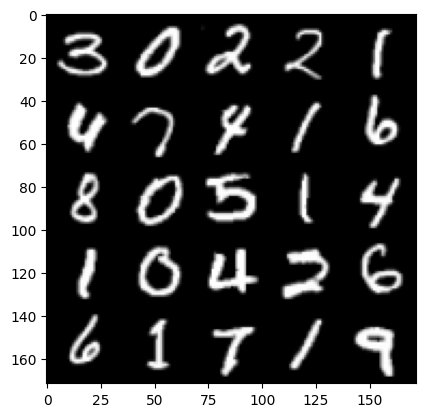

 58%|█████▊    | 546/938 [00:21<00:14, 27.25it/s]

[Epoch 154], step 145000: [G loss:1.4287863334417337], [D loss:1.964964262890815,acc : 96.875]


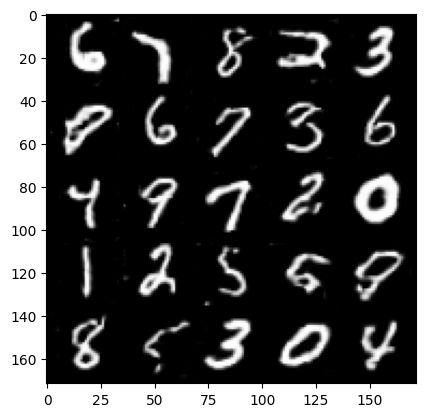

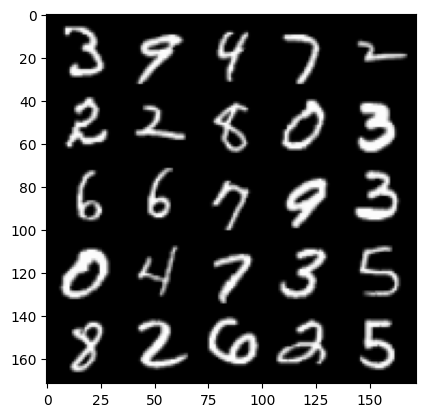

 91%|█████████▏| 858/938 [00:33<00:02, 26.77it/s]

[Epoch 159], step 150000: [G loss:1.4497757919669205], [D loss:1.958366172099108,acc : 96.09375]


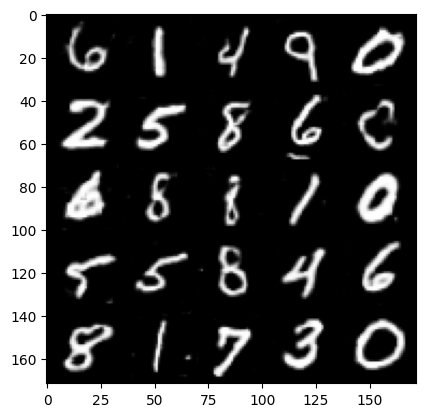

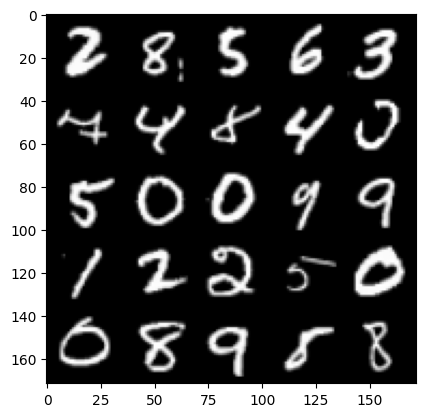

 24%|██▍       | 228/938 [00:09<00:27, 26.08it/s]

[Epoch 165], step 155000: [G loss:1.5060112225890183], [D loss:1.933915822052963,acc : 95.3125]


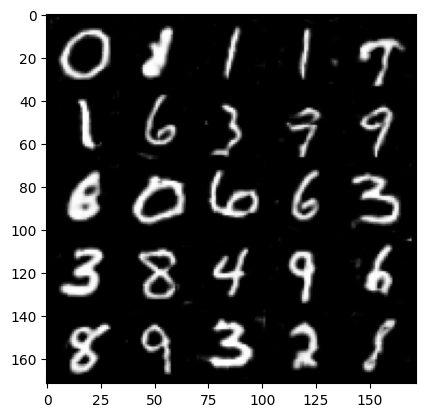

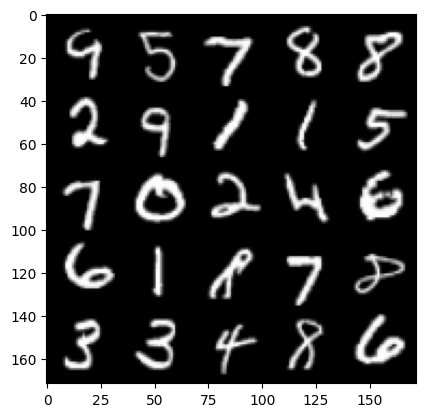

 58%|█████▊    | 540/938 [00:21<00:15, 26.12it/s]

[Epoch 170], step 160000: [G loss:1.5521282778024663], [D loss:1.9183645293712632,acc : 96.09375]


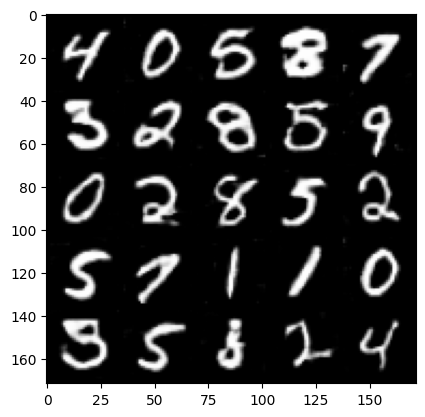

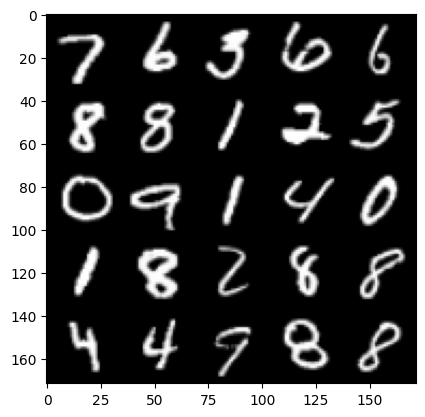

 90%|█████████ | 848/938 [00:33<00:03, 23.16it/s]

[Epoch 175], step 165000: [G loss:1.5966472019910858], [D loss:1.8859671849489206,acc : 96.875]


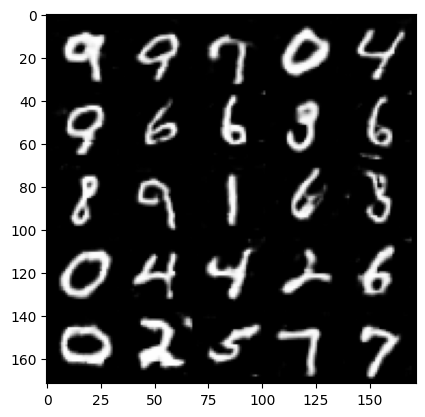

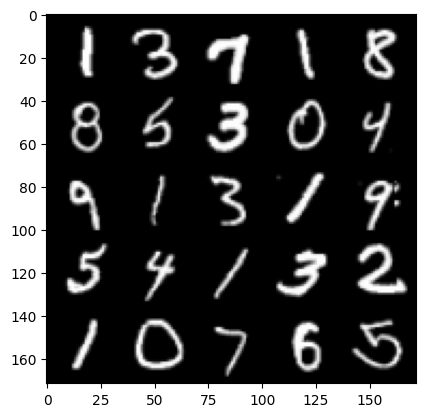

 24%|██▎       | 221/938 [00:09<00:27, 25.76it/s]

[Epoch 181], step 170000: [G loss:1.661799161088458], [D loss:1.8620907302379557,acc : 96.09375]


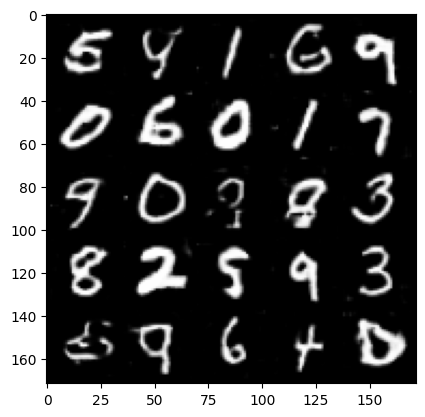

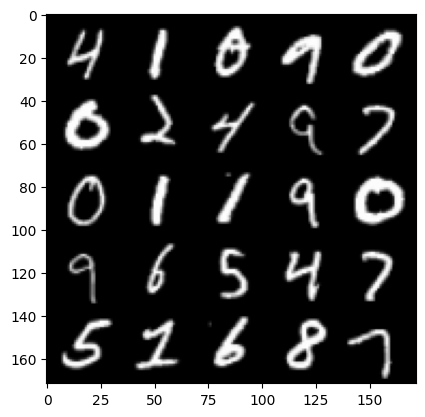

 57%|█████▋    | 531/938 [00:22<00:17, 23.18it/s]

[Epoch 186], step 175000: [G loss:1.7066894604325245], [D loss:1.8490923565149258,acc : 95.3125]


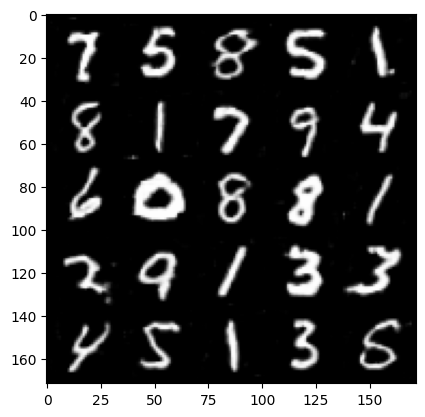

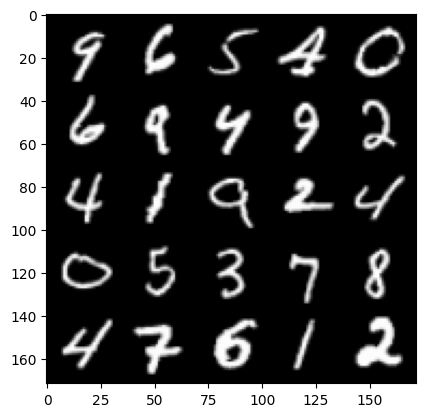

 90%|████████▉ | 841/938 [00:35<00:04, 21.56it/s]

[Epoch 191], step 180000: [G loss:1.7714305869698534], [D loss:1.8323335953473996,acc : 96.875]


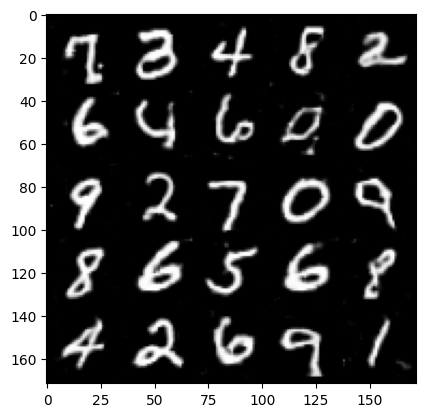

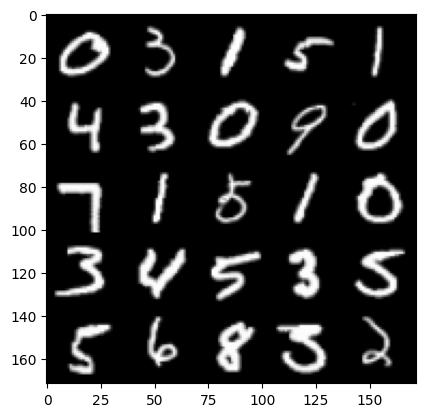

 23%|██▎       | 213/938 [00:08<00:29, 24.50it/s]

[Epoch 197], step 185000: [G loss:1.802082736480238], [D loss:1.821385269498819,acc : 97.65625]


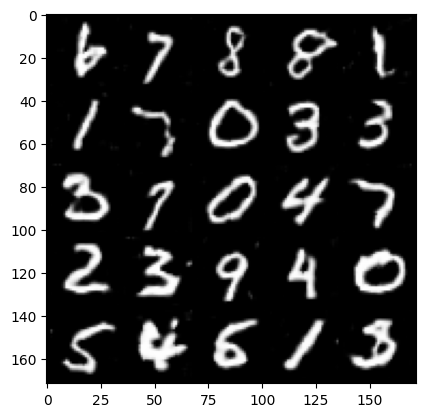

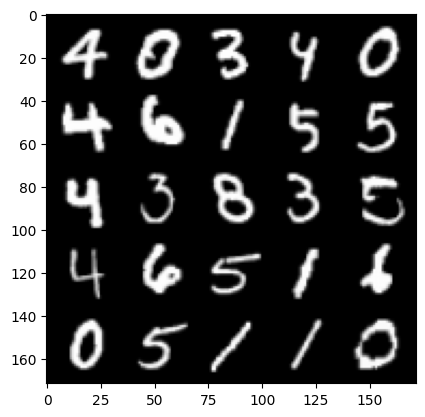

100%|██████████| 938/938 [00:40<00:00, 23.05it/s]


In [26]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for i,(imgs,labels) in enumerate(tqdm(dataloader)):
        # Configure input
        real_imgs,labels = imgs.to(device),labels.to(device)

        # Adversarial ground truths
        valid = torch.ones(real_imgs.size(0),1).to(device)
        fake =  torch.zeros(real_imgs.size(0),1).to(device)

        # print('real img',real_imgs.device)
        # print('labels',labels.device)
        #----------------
        #Train Generator
        #----------------
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(real_imgs.size(0),latent_dim).to(device)
        gen_labels = torch.randint(0,n_classes,(real_imgs.size(0),)).to(device)

        #generate a batch of images
        gen_images = generator(z,gen_labels)
        validity , pred_label = discriminator(gen_images)

        #loss measures ability of generator to fool discriminator
        g_loss = 0.5 * (adversarial_loss(validity,valid)  + auxialiary_loss(pred_label,gen_labels))

        g_loss.backward()
        optimizer_G.step()

        #-----------------
        #Train Discriminator
        #-----------------
        optimizer_D.zero_grad()

        #loss for real
        real_validity,real_aux = discriminator(real_imgs)
        real_loss = adversarial_loss(real_validity,valid) + auxialiary_loss(real_aux,labels)

        #loss for fake
        fake_validity,fake_aux = discriminator(gen_images.detach())
        fake_loss = adversarial_loss(fake_validity,fake) + auxialiary_loss(fake_aux,gen_labels)

        #total discriminator loss
        d_loss = (real_loss + fake_loss) / 2


        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)


        d_loss.backward()
        optimizer_D.step()

        # Keep track of the average generator loss
        mean_generator_loss += g_loss.item() / display_step

        # Keep track of the average discriminator loss
        mean_discriminator_loss += d_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"[Epoch {epoch}], step {cur_step}: [G loss:{mean_generator_loss}], [D loss:{mean_discriminator_loss},acc : {100 * d_acc}]")

            show_tensor_images(gen_images)
            show_tensor_images(real_imgs)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1